In [1]:
%pylab inline
plt.rcParams['figure.figsize'] = [10, 5]
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load dataset
labels = ["mntcm", "mxtwm", "rfseas", "tann", "latitude", "longitude", "y"]
dataset = pd.read_csv('dataset_bees.csv', names=labels)
dataset

,mntcm,mxtwm,rfseas,tann,latitude,longitude,y
0,6.0,23.0,36.0,14.0,17.0,50.0,0.0
1,6.0,23.0,36.0,14.0,17.0,51.0,1.0
2,6.0,23.0,35.0,13.0,17.0,52.0,0.0
3,5.0,22.0,35.0,13.0,17.0,53.0,0.0
4,5.0,23.0,35.0,13.0,17.0,54.0,0.0
...,...,...,...,...,...,...,...
9433,7.0,27.0,76.0,17.0,108.0,77.0,0.0
9434,7.0,27.0,76.0,16.0,108.0,78.0,0.0
9435,5.0,28.0,76.0,15.0,108.0,79.0,0.0
9436,8.0,27.0,76.0,17.0,108.0,80.0,0.0


y
0.0    9310
1.0     128
dtype: int64


<AxesSubplot:xlabel='y', ylabel='count'>

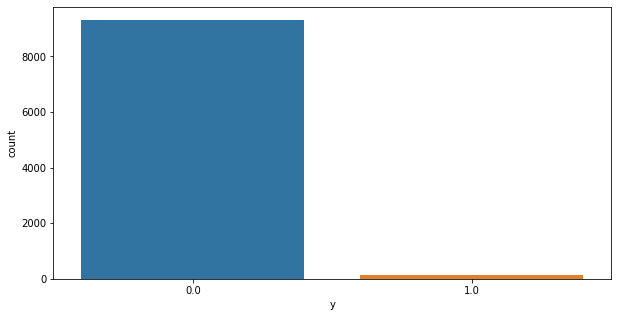

In [3]:
# drop latitude and longitude
#dataset = dataset.drop(['latitude', 'longitude'], axis=1)
# drop nan values
#dataset = dataset.dropna()

# visualize count info
print(dataset.groupby('y').size())
sns.countplot(x=dataset["y"], label="Count")


In [4]:
print('------------------Antes------------------')
print(dataset.loc[8483])
print(dataset.loc[9346])
dataset = dataset.fillna(dataset[dataset['y'] == 1].groupby('y').transform('mean'))
print('------------------Depois-----------------')
print(dataset.loc[8483])
print(dataset.loc[9346])

------------------Antes------------------
mntcm          NaN
mxtwm          NaN
rfseas         NaN
tann           NaN
latitude      89.0
longitude    135.0
y              1.0
Name: 8483, dtype: float64
mntcm          NaN
mxtwm          NaN
rfseas         NaN
tann           NaN
latitude     101.0
longitude    103.0
y              1.0
Name: 9346, dtype: float64
------------------Depois-----------------
mntcm          3.158730
mxtwm         29.031746
rfseas        46.642857
tann          14.396825
latitude      89.000000
longitude    135.000000
y              1.000000
Name: 8483, dtype: float64
mntcm          3.158730
mxtwm         29.031746
rfseas        46.642857
tann          14.396825
latitude     101.000000
longitude    103.000000
y              1.000000
Name: 9346, dtype: float64


In [5]:
# visualize all labels
dataset.describe()

,mntcm,mxtwm,rfseas,tann,latitude,longitude,y
count,9438.000000,9438.000000,9438.000000,9438.000000,9438.000000,9438.000000,9438.000000
mean,1.581089,28.060189,38.678882,12.767302,56.213393,98.466306,0.013562
std,2.790985,3.896999,14.775476,2.866531,23.238731,36.469730,0.115671
min,-11.000000,10.000000,11.000000,-1.000000,17.000000,32.000000,0.000000
25%,0.000000,25.000000,27.000000,11.000000,36.000000,68.000000,0.000000
50%,1.000000,28.000000,37.000000,13.000000,54.000000,96.000000,0.000000
75%,4.000000,31.000000,51.000000,15.000000,76.000000,126.000000,0.000000
max,8.000000,36.000000,78.000000,18.000000,109.000000,185.000000,1.000000


mntcm           AxesSubplot(0.125,0.536818;0.110714x0.343182)
mxtwm        AxesSubplot(0.257857,0.536818;0.110714x0.343182)
rfseas       AxesSubplot(0.390714,0.536818;0.110714x0.343182)
tann         AxesSubplot(0.523571,0.536818;0.110714x0.343182)
latitude     AxesSubplot(0.656429,0.536818;0.110714x0.343182)
longitude    AxesSubplot(0.789286,0.536818;0.110714x0.343182)
dtype: object

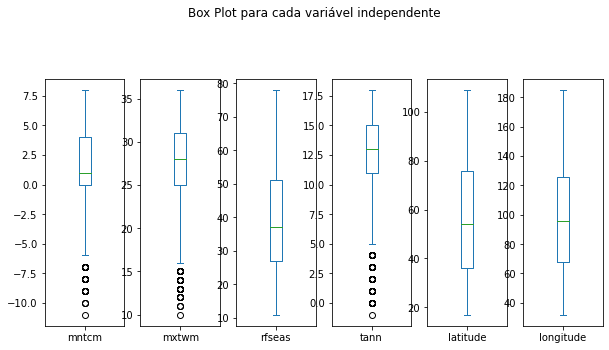

In [6]:
dataset.drop('y', axis=1).plot(kind='box', subplots=True, layout=(2,6),
                                        sharex=False, sharey=False, figsize=(10,10),
                                        title='Box Plot para cada variável independente')

## Balance Data

Imbalanced
0: 9310
1: 128


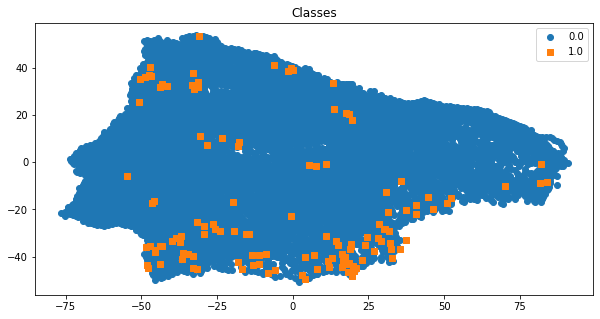

Under-Sample
0: 128
1: 128


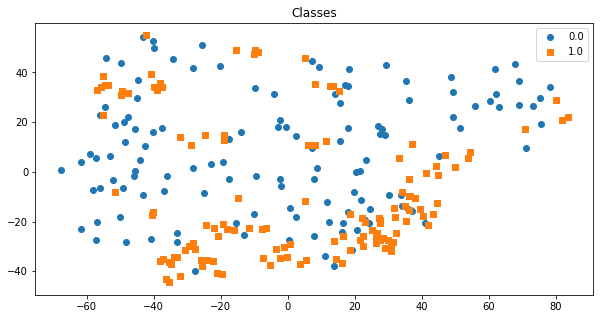

Over-Sample
0: 9310
1: 9310


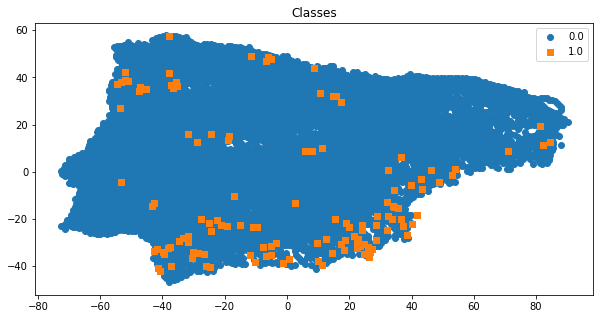

SMOTE
0: 9310
1: 9310


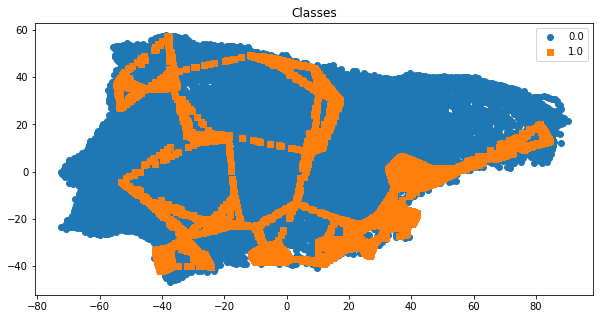

In [7]:
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


X = dataset.drop('y', axis=1).values
y = dataset['y'].values

DATA = {
  'Imbalanced':{'X':None, 'y':None},
  'Under-Sample':{'X':None, 'y':None},
  'Over-Sample':{'X':None, 'y':None},
  'SMOTE':{'X':None, 'y':None}
}

def balance_data(X, y, algo=None):
  
  if algo is not None:
    X_balanced, y_balanced = algo.fit_resample(X, y)
  else:
    X_balanced, y_balanced = X, y

  #sns.countplot(x=y_balanced, label="Count")
  print(f'0: {np.count_nonzero(y_balanced == 0)}\n1: {np.count_nonzero(y_balanced == 1)}')
  
  def plot2d(X, y):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title('Classes')
    plt.legend(loc='upper right')
    plt.show()

  # plot data distribution in 2d
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_balanced)
  plot2d(X_pca, y_balanced)
  
  return X_balanced, y_balanced

keys_algos = zip(DATA.keys(), [None, RandomUnderSampler(), RandomOverSampler(), SMOTE()])
for k,algo in keys_algos:
  print(k)
  DATA[k]['X'], DATA[k]['y'] = balance_data(X, y, algo=algo)



## Data Normalization

In [8]:
def normalize(X):
  return preprocessing.StandardScaler().fit(X).transform(X)
for k in DATA.keys():
  # remove latitude and longitude
  DATA[k]['X'] = DATA[k]['X'][:, :-2]
  DATA[k]['X'] = normalize(DATA[k]['X'])

## Classifiers Comparison

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc
from scipy import interp

class Classifiers:
  def __init__(self, X, y, models={}):
    self.X = X
    self.y = y
    self.models = models
    self.skf = StratifiedKFold(n_splits=10)

  def run_all(self):
    plots = []
    for k,model in self.models.items():
      # train model
      print(f'----------- {k} -----------')
      tprs = []
      aucs = []
      mean_fpr = np.linspace(0, 1, 100)
      for i,(train,test) in enumerate(self.skf.split(self.X, self.y)):
        # train
        model.fit(self.X[train],self.y[train])
        # test model
        y_pred = model.predict(self.X[test])
        # ROC curve
        fpr, tpr, t = roc_curve(self.y[test], y_pred)
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)'%(i+1,roc_auc))
    
      #plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
      mean_tpr = np.mean(tprs, axis=0)
      mean_auc = auc(mean_fpr, mean_tpr)
      plots.append((mean_fpr, mean_tpr, mean_auc))
      #plt.plot(mean_fpr, mean_tpr, color='blue',
      #        label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

      #plt.xlabel('False Positive Rate')
      #plt.ylabel('True Positive Rate')
      #plt.title('ROC')
      #plt.legend(loc="lower right")
      #plt.show()
    return plots

Imbalanced
----------- Multi Layer Percepetron -----------
Under-Sample
----------- Multi Layer Percepetron -----------
Over-Sample
----------- Multi Layer Percepetron -----------
SMOTE
----------- Multi Layer Percepetron -----------
Imbalanced
Under-Sample
Over-Sample
SMOTE


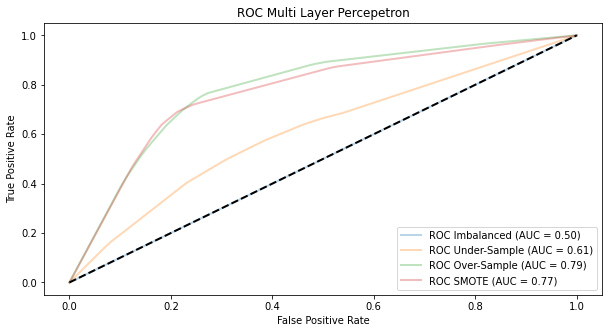

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

plots_per_model = [[], [], [], [], []]

for k in DATA.keys():
  print(k)
  classifiers = Classifiers(
    X=DATA[k]['X'], y=DATA[k]['y'],
    models={
      #"K Neighbors Classifier":KNeighborsClassifier(n_neighbors=5, n_jobs=2),
      #"Support Vector Machine":SVC(),
      #"Decision Tree Classifier":DecisionTreeClassifier(),
      #"Random Forest Classifier":RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=2),
      "Multi Layer Percepetron":MLPClassifier(random_state=1, max_iter=300),
    }
  )
  for i,p in enumerate(classifiers.run_all()):
    plots_per_model[i].append(p)

# plot
model_names = ["K Neighbors Classifier", "Support Vector Machine", 
               "Decision Tree Classifier","Random Forest Classifier",
               "Multi Layer Percepetron"]
model_names = ["Multi Layer Percepetron"]
for i,model_name in enumerate(model_names):
  
  for j,p in enumerate(plots_per_model[i]):
    fpr, tpr, auc = p
    print(list(DATA.keys())[j])
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC {list(DATA.keys())[j]} (AUC = %0.2f)'%(auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC {model_name}')
  plt.legend(loc="lower right")
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  plt.show()
  if i != 1: break
    